In [2]:
import regex
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy

import pyLDAvis
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# retrieving file with collected Facebook data
fb_data = pd.read_csv('facebook_covid_posts_updated.csv', encoding = "latin1")
fb_data.head(2)


In [ ]:
fb_data.columns

In [ ]:
fb_data.info()

In [ ]:
data=[fb_data['News Org.'], fb_data['Time Posted'], fb_data["Post's Title"], fb_data["Post's Text"],
      fb_data['# Shares'], fb_data['# Comments'], fb_data['# Total Reactions'], fb_data["# Like"], 
      fb_data['# Love'], fb_data['# Haha'], fb_data['# Wow'], fb_data["# Sad"], fb_data['# Angry']]
      
headers =  ['organization', 'date', 'title', 'post', 'shares', 'comments', 'total_reactions', 'like', 'love',
             'haha', 'wow', 'sad', 'angry']       
df1 = pd.concat(data, keys=headers, axis=1, )   
df1.head()

In [ ]:
df1.info()

In [ ]:
# removing rows with no posts
df1 = df1[df1['post'].notna()]
df1.info()


In [ ]:
df1.fillna("",inplace=True)

In [ ]:
# Converting date to datetime format and extracting year and month only (omitting a "day" information)
df1['yearMonth'] = pd.to_datetime(df1['date'])
df1['yearMonth'] = df1['yearMonth'].dt.strftime('%Y-%m')
df1.head(2)

In [ ]:
monthlyPosts = df1.groupby(['yearMonth', 'organization']).size().reset_index().rename(columns={0: 'postsCount'})
monthlyPosts = monthlyPosts.sort_values(['yearMonth', 'postsCount'], ascending = (True, False))
monthlyPosts

In [ ]:
# Creating a pivot table with Covid-related FB post per organization per month
postCountsPivot=pd.pivot_table(monthlyPosts,index=['organization'],columns='yearMonth',values='postsCount',aggfunc=sum,fill_value=0)
postCountsPivot

In [ ]:
#***********************************************************************************************************************
df1.columns

In [ ]:
# creating a list objects for all the posts per each organization

postsABCNews= df1['post'][df1['organization'] == 'ABCNews'].tolist()
titlesABCNews = df1['title'][df1['organization'] == 'ABCNews'].tolist()
allABCNews = postsABCNews + titlesABCNews
len(allABCNews)

In [ ]:
postsBBC= df1['post'][df1['organization'] == 'BBC'].tolist()
titlesBBC = df1['title'][df1['organization'] == 'BBC'].tolist()
allBBC = postsBBC + titlesBBC
len(allBBC)

In [ ]:
postsCNN= df1['post'][df1['organization'] == 'CNN'].tolist()
titlesCNN = df1['title'][df1['organization'] == 'CNN'].tolist()
allCNN = postsCNN + titlesCNN
len(allCNN)

In [ ]:
postsFOX= df1['post'][df1['organization'] == 'FOX'].tolist()
titlesFOX = df1['title'][df1['organization'] == 'FOX'].tolist()
allFOX = postsFOX + titlesFOX
len(allFOX)

In [ ]:
postsNBC= df1['post'][df1['organization'] == 'NBC'].tolist()
titlesNBC = df1['title'][df1['organization'] == 'NBC'].tolist()
allNBC = postsNBC + titlesNBC
len(allNBC)

In [ ]:
postsNYT= df1['post'][df1['organization'] == 'NYT'].tolist()
titlesNYT = df1['title'][df1['organization'] == 'NYT'].tolist()
allNYT = postsNYT + titlesNYT
len(allNYT)

In [ ]:
postsTheGuardian= df1['post'][df1['organization'] == 'TheGuardian'].tolist()
titlesTheGuardian = df1['title'][df1['organization'] == 'TheGuardian'].tolist()
allTheGuardian = postsTheGuardian + titlesTheGuardian
len(allTheGuardian)

In [ ]:
postsUSAToday= df1['post'][df1['organization'] == 'USAToday'].tolist()
titlesUSAToday = df1['title'][df1['organization'] == 'USAToday'].tolist()
allUSAToday = postsUSAToday + titlesUSAToday
len(allUSAToday)

In [ ]:
postsWASH= df1['post'][df1['organization'] == 'WASH'].tolist()
titlesWASH = df1['title'][df1['organization'] == 'WASH'].tolist()
allWASH = postsWASH + titlesWASH
len(allWASH)

In [ ]:
postsWSJ= df1['post'][df1['organization'] == 'WSJ'].tolist()
titlesWSJ = df1['title'][df1['organization'] == 'WSJ'].tolist()
allWSJ = postsWSJ + titlesWSJ
len(allWSJ)

In [ ]:
allPosts = [allABCNews, allBBC, allCNN, allFOX, allNBC, allNYT, allTheGuardian, allUSAToday, allWASH, allWSJ]
allPosts[0][0]

In [ ]:
# cleaning titles and posts
allCleanPosts = []
for index in range(0,10):
    organizationPosts = allPosts[index];
    newOrganizationPosts = []
    for item in organizationPosts:
        
        #removing urls
        item = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', item)
       
        # removing whitespace characters (tabs, new line, etc.)
        item = re.sub('\s+', ' ', item) 
    
        # removing non-alphanumberic characters (dots, commas, special characters if any, etc.)
        item = re.sub('\W+', ' ', item)
        
        item = item.lower()
                
        # changing to lowercase and tokanizing 
        item = nltk.word_tokenize(item.lower())
        #removing stopwords
        for word in item:
            if word in stopwords.words('english'):
                item.remove(word)
                     
        newOrganizationPosts.append(item)    
    allCleanPosts.append(newOrganizationPosts)
print(allCleanPosts[0][0:2]) 

In [ ]:
allPostsWithBilgram = []
for index in range(0,10):
    orgPosts = allCleanPosts[index]
    # creating a set of bigrams for pairs of words frequently occuring in the same post or title
    bigrams = gensim.models.Phrases(orgPosts, min_count=5, threshold=150) 

    # building bigram model
    bigram_mod = gensim.models.phrases.Phraser(bigrams)
    
    orgPostsWithBigram = []  
    for post in orgPosts:
        orgPostsWithBigram.append(bigram_mod[post])
        
    allPostsWithBilgram.append(orgPostsWithBigram)
    
print(allPostsWithBilgram[0][10:15] )   

In [ ]:
import spacy 
nlp = spacy.load('en_core_web_sm')  # <--downloading English core

ABCNews = []
BBC = []
CNN = []
FOX = []
NBC = []
NYT = []
TheGuardian = []
USAToday = []
WASH = []
WSJ =[]


orgs = [ABCNews, BBC, CNN, FOX, NBC, NYT, TheGuardian, USAToday, WASH, WSJ]

In [ ]:
# iterating through reviews to lemmatize the words
all_lemma = []
for index in range(0,10):
    lemmaPosts = []
    for item in allPostsWithBilgram[index]: 
        spacy_doc = nlp(" ".join(item))
        lemma_post = []
        for word in spacy_doc:
            lemma_post.append(word.lemma_) 
        lemmaPosts.append(lemma_post)
    orgs[index] = lemmaPosts
print(orgs[2][0:5])

In [ ]:
# creating dictionary
orgPosts = orgs[0]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# sample view of sorted words' frequencies in the firsts post
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()


In [ ]:
import pyLDAvis.gensim_models

#*******************************************below is for ABCNews ***********************************************

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

In [ ]:
# creating dictionary
orgPosts = orgs[1]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                  #  ***************************below is for BBC *********************************

In [ ]:
# creating dictionary
orgPosts = orgs[2]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis
                          #****************** below is for CNN ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[3]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                        #****************** below is for FOX ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[4]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                        #  #****************** below is for NBC ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[5]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                        #   #****************** below is for NYT ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[6]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                        #   #****************** below is for The Guardian ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[7]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                   # *  #****************** below is for USA Today ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[8]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                  #   #****************** below is for Washington Post ****************************

In [ ]:
# creating dictionary
orgPosts = orgs[9]
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis                  #   #****************** below is for Wall Street Journal ****************************

### Resampling and Plotting the monthly data of each News organization Time series

In [3]:
df2 = pd.read_csv('facebook_covid_posts_updated.csv')
df2.head()

,Unnamed: 0,Unnamed: 0.1,News Org.,Post's Title,Added link,Time Posted,Posted By,# Shares,# Total Reactions,# Like,# Love,# Haha,# Wow,# Sad,# Angry,# Comments,Post's Text
0,0,1,CNN,Thousands of meals meant for an Ohio sports fe...,https://cnn.it/2VUDfSU,2020-03-07,CNN,3630.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,272.0,Instead of throwing it away because of a chang...
1,1,2,CNN,"In the middle of a coronavirus outbreak, peopl...",https://cnn.it/330y3y0,2020-03-07,CNN,189.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,153.0,There's a new reality beginning to form in the...
2,2,3,CNN,Coronavirus spreads as outbreak clusters grow ...,https://cnn.it/2TxDi5a,2020-03-07,CNN,473.0,1653.0,1010.0,11.0,16.0,190.0,416.0,10.0,372.0,The number of US coronavirus cases more than t...
3,3,10,CNN,Adoptions from China are being held up by the ...,https://www.facebook.com/cnn/videos/1632284580...,2020-03-07,CNN,6400.0,24250.0,13370.0,3659.0,94.0,381.0,6661.0,85.0,1576.0,Many families in the US were just days or week...
4,4,11,CNN,Anderson Cooper Full Circle - CNN,http://cnn.com/FullCircle,2020-03-06,CNN,30.0,278.0,173.0,3.0,0.0,19.0,79.0,4.0,58.0,We’ll speak with Amir Medawar who pushed to ha...


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4962 non-null   int64  
 1   Unnamed: 0.1       4962 non-null   int64  
 2   News Org.          4962 non-null   object 
 3   Post's Title       4772 non-null   object 
 4   Added link         4962 non-null   object 
 5   Time Posted        4962 non-null   object 
 6   Posted By          4962 non-null   object 
 7   # Shares           4962 non-null   float64
 8   # Total Reactions  4962 non-null   float64
 9   # Like             4962 non-null   float64
 10  # Love             4962 non-null   float64
 11  # Haha             4962 non-null   float64
 12  # Wow              4962 non-null   float64
 13  # Sad              4962 non-null   float64
 14  # Angry            4962 non-null   float64
 15  # Comments         4962 non-null   float64
 16  Post's Text        4557 

In [5]:
data2=[df2['News Org.'], df2['Time Posted'], df2["Post's Title"], df2["Post's Text"],
      df2['# Shares'], df2['# Comments'], df2['# Total Reactions'], df2["# Like"], 
      df2['# Love'], df2['# Haha'], df2['# Wow'], df2["# Sad"], df2['# Angry']]
      
headers2 =  ['Organization', 'Date', 'Title', 'Post', 'Shares', 'Comments', 'Total_reactions', 'Like', 'Love',
             'Haha', 'Wow', 'Sad', 'Angry']       
df3 = pd.concat(data2, keys=headers2, axis=1)   
df3.head()

,Organization,Date,Title,Post,Shares,Comments,Total_reactions,Like,Love,Haha,Wow,Sad,Angry
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,190.0,416.0,10.0
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,381.0,6661.0,85.0
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,We’ll speak with Amir Medawar who pushed to ha...,30.0,58.0,278.0,173.0,3.0,0.0,19.0,79.0,4.0


In [6]:
df3['ABCNews'] = df3['Organization'].apply(lambda x: 1 if x == 'ABCNews' else 0)
df3['BBC'] = df3['Organization'].apply(lambda x: 1 if x == 'BBC' else 0)
df3['CNN'] = df3['Organization'].apply(lambda x: 1 if x == 'CNN' else 0)
df3['FOX'] = df3['Organization'].apply(lambda x: 1 if x == 'FOX' else 0)
df3['NBC'] = df3['Organization'].apply(lambda x: 1 if x == 'NBC' else 0)
df3['NYT'] = df3['Organization'].apply(lambda x: 1 if x == 'NYT' else 0)
df3['TheGuardian'] = df3['Organization'].apply(lambda x: 1 if x == 'TheGuardian' else 0)
df3['USAToday'] = df3['Organization'].apply(lambda x: 1 if x == 'USAToday' else 0)
df3['WASH'] = df3['Organization'].apply(lambda x: 1 if x == 'WASH' else 0)
df3['WSJ'] = df3['Organization'].apply(lambda x: 1 if x == 'WSJ' else 0)

df3.head(10)

,Organization,Date,Title,Post,Shares,Comments,Total_reactions,Like,Love,Haha,...,ABCNews,BBC,CNN,FOX,NBC,NYT,TheGuardian,USAToday,WASH,WSJ
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,...,0,0,1,0,0,0,0,0,0,0
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,...,0,0,1,0,0,0,0,0,0,0
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,...,0,0,1,0,0,0,0,0,0,0
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,...,0,0,1,0,0,0,0,0,0,0
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,We’ll speak with Amir Medawar who pushed to ha...,30.0,58.0,278.0,173.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0,0
5,CNN,2020-03-06,WHO says 'this is not a drill' as coronavirus ...,"""This is not a drill. This is not the time to ...",1217.0,412.0,3078.0,2425.0,27.0,56.0,...,0,0,1,0,0,0,0,0,0,0
6,CNN,2020-03-06,"Here's who needs to wear a face mask, and who ...",The advice on whether people should wear masks...,229.0,146.0,410.0,383.0,1.0,16.0,...,0,0,1,0,0,0,0,0,0,0
7,CNN,2020-03-06,Coronavirus outbreak leaves busy tourist attra...,Public places that are usually packed with vis...,265.0,111.0,1270.0,794.0,8.0,16.0,...,0,0,1,0,0,0,0,0,0,0
8,CNN,2020-03-06,Drastic measures and closures as the world rea...,"There are now more than 90,000 cases of corona...",23327.0,1927.0,47095.0,37538.0,951.0,249.0,...,0,0,1,0,0,0,0,0,0,0
9,CNN,2020-03-05,US tries to identify people in contact with in...,US officials are trying to identify people who...,534.0,267.0,1458.0,750.0,7.0,36.0,...,0,0,1,0,0,0,0,0,0,0


In [7]:
df3['Date'] = pd.to_datetime(df3['Date'])
df3.head(10)

,Organization,Date,Title,Post,Shares,Comments,Total_reactions,Like,Love,Haha,...,ABCNews,BBC,CNN,FOX,NBC,NYT,TheGuardian,USAToday,WASH,WSJ
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,...,0,0,1,0,0,0,0,0,0,0
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,...,0,0,1,0,0,0,0,0,0,0
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,...,0,0,1,0,0,0,0,0,0,0
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,...,0,0,1,0,0,0,0,0,0,0
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,We’ll speak with Amir Medawar who pushed to ha...,30.0,58.0,278.0,173.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0,0
5,CNN,2020-03-06,WHO says 'this is not a drill' as coronavirus ...,"""This is not a drill. This is not the time to ...",1217.0,412.0,3078.0,2425.0,27.0,56.0,...,0,0,1,0,0,0,0,0,0,0
6,CNN,2020-03-06,"Here's who needs to wear a face mask, and who ...",The advice on whether people should wear masks...,229.0,146.0,410.0,383.0,1.0,16.0,...,0,0,1,0,0,0,0,0,0,0
7,CNN,2020-03-06,Coronavirus outbreak leaves busy tourist attra...,Public places that are usually packed with vis...,265.0,111.0,1270.0,794.0,8.0,16.0,...,0,0,1,0,0,0,0,0,0,0
8,CNN,2020-03-06,Drastic measures and closures as the world rea...,"There are now more than 90,000 cases of corona...",23327.0,1927.0,47095.0,37538.0,951.0,249.0,...,0,0,1,0,0,0,0,0,0,0
9,CNN,2020-03-05,US tries to identify people in contact with in...,US officials are trying to identify people who...,534.0,267.0,1458.0,750.0,7.0,36.0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# Set Index to Time series
df3 = df3.set_index('Date')

#Sorted Index based on Time
df_sorted = df3.sort_index()
df_sorted.head(10)

,Organization,Title,Post,Shares,Comments,Total_reactions,Like,Love,Haha,Wow,...,ABCNews,BBC,CNN,FOX,NBC,NYT,TheGuardian,USAToday,WASH,WSJ
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,CNN,President Trump is expected to visit the CDC t...,"It's unclear if Vice President Mike Pence, who...",86.0,848.0,1319.0,383.0,18.0,621.0,32.0,...,0,0,1,0,0,0,0,0,0,0
2020-03-01,WSJ,Shrinking Profit Prospects Add to Threat for S...,There are few signs the economic fears prompte...,13.0,24.0,65.0,54.0,1.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
2020-03-01,USAToday,Paris shuts down famed Louvre museum as corona...,The world's most popular museum welcomes tens ...,1881.0,152.0,3660.0,1554.0,11.0,13.0,1060.0,...,0,0,0,0,0,0,0,1,0,0
2020-03-01,USAToday,"'SNL' cold open: Mike Pence, Democratic candid...",A Mike Pence press conference on the coronavir...,24.0,17.0,305.0,234.0,13.0,57.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2020-03-01,CNN,CNN International,The move comes amid fears over the spread of c...,97.0,39.0,408.0,261.0,4.0,5.0,118.0,...,0,0,1,0,0,0,0,0,0,0
2020-03-01,USAToday,Talking to children about coronavirus: Stay ho...,"Be careful what you say around children, as an...",48.0,25.0,278.0,271.0,2.0,3.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2020-03-01,NYT,Coronavirus Live Updates: New Fears in Washing...,Washington State declared a state of emergency...,532.0,285.0,1971.0,932.0,6.0,15.0,361.0,...,0,0,0,0,0,1,0,0,0,0
2020-03-01,NYT,How Prepared Is the U.S. for a Coronavirus Out...,The U.S. is among the countries best prepared ...,102.0,218.0,490.0,263.0,2.0,73.0,29.0,...,0,0,0,0,0,1,0,0,0,0
2020-03-02,CNN,CNN Business,Stocks are set to open higher Monday morning a...,35.0,114.0,334.0,278.0,8.0,41.0,5.0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4962 entries, 2020-03-01 to 2021-04-10
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Organization     4962 non-null   object 
 1   Title            4772 non-null   object 
 2   Post             4557 non-null   object 
 3   Shares           4962 non-null   float64
 4   Comments         4962 non-null   float64
 5   Total_reactions  4962 non-null   float64
 6   Like             4962 non-null   float64
 7   Love             4962 non-null   float64
 8   Haha             4962 non-null   float64
 9   Wow              4962 non-null   float64
 10  Sad              4962 non-null   float64
 11  Angry            4962 non-null   float64
 12  ABCNews          4962 non-null   int64  
 13  BBC              4962 non-null   int64  
 14  CNN              4962 non-null   int64  
 15  FOX              4962 non-null   int64  
 16  NBC              4962 non-null   int64  
 

In [10]:
df_monthly_post = df_sorted.resample('M')['ABCNews', 'BBC', 'CNN', 'FOX', 'NBC', 'NYT', 'TheGuardian', 'USAToday', 'WASH', 'WSJ' ].sum()
df_monthly_post.head(10)

,ABCNews,BBC,CNN,FOX,NBC,NYT,TheGuardian,USAToday,WASH,WSJ
Date,,,,,,,,,,
2020-03-31,248,45,199,46,160,150,186,135,48,151
2020-04-30,0,9,0,0,0,0,0,0,0,0
2020-05-31,0,28,24,6,0,12,0,77,25,79
2020-06-30,69,23,93,8,68,74,85,49,23,116
2020-07-31,0,7,0,0,0,0,0,0,0,0
2020-08-31,0,12,9,4,0,8,7,16,13,42
2020-09-30,45,16,74,3,51,72,94,55,18,89
2020-10-31,0,0,0,0,0,0,0,0,0,0
2020-11-30,0,23,19,8,0,0,11,33,21,53


<AxesSubplot:title={'center':'News Organizations Time Series'}, xlabel='Date'>

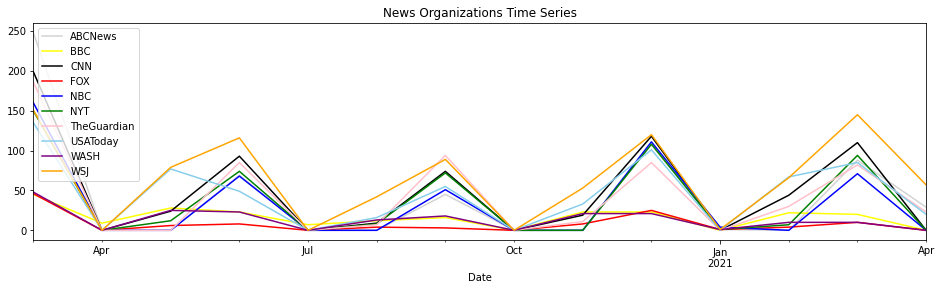

In [12]:
plot_monthly = dict(figsize=(16,4),color=['lightgrey', 'yellow', 'black', 'red', 'blue', 'green', 'pink', 'skyblue', 'purple', 'orange'],title='News Organizations Time Series')
df_monthly_post.plot(**plot_monthly)